# GPU-Billiard Balls and the Boltzmann Distribution in Python


Source video: http://youtube.com/watch?v=iSEAidM-DDI

Source code: https://github.com/lukepolson/youtube_channel/blob/main/Python%20GPU/multibody_boltzmann.ipynb

In [7]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Initial conditions
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

# Color particles the start on either side
ixr = r[0] >  0.5 #right
ixl = r[0] <= 0.5 #left

In [9]:
# ids are tensors, which live on the graphics card
ids = torch.arange(n_particles)

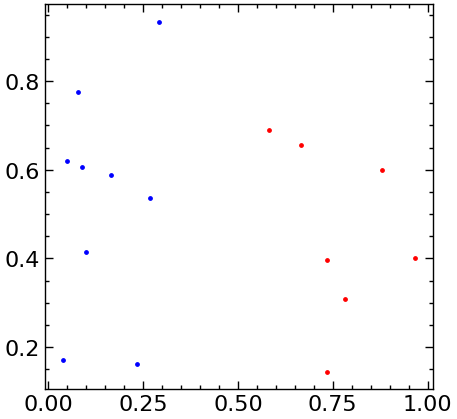

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

In [11]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

# Part 1: Distance Between all Pairs

In [12]:
ids_pairs = torch.combinations(ids,2).to(device)